In [11]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [12]:
import os
# Convert HDF5 to pickle if it doesn't already exist
pkl_path = os.path.expanduser('~/DCI-Bitcoin-Fee-Estimation/data/10-17-2025-with-exchange-datalake.pkl')
if not os.path.exists(pkl_path):
    txs_temp = pd.read_hdf(h5_path, key='mempool_transactions')
    txs_temp.to_pickle(pkl_path)

txs = pd.read_pickle(pkl_path)

In [3]:
# Display all the columns
print(txs.columns)


Index(['inputs_hash', 'tx_id', 'found_at', 'mined_at', 'pruned_at',
       'child_txid', 'absolute_fee', 'fee_rate', 'version', 'seen_in_mempool',
       'waittime', 'rbf_fee_total', 'mempool_size', 'mempool_tx_count',
       'weight', 'size', 'min_respend_time', 'exchange_is_sender',
       'exchange_is_receiver'],
      dtype='object')


In [21]:
# Examine the rbf_fee_total column
print("RBF Fee Total Analysis:")
print(f"Data type: {txs['rbf_fee_total'].dtype}")
print(f"\nBasic statistics:")
print(txs['rbf_fee_total'].describe())
print(f"\nUnique values count: {txs['rbf_fee_total'].nunique()}")
print(f"Null values: {txs['rbf_fee_total'].isna().sum()}")
print(f"\nValue counts (top 20):")
print(txs['rbf_fee_total'].value_counts().head(20))
print(f"\nMin: {txs['rbf_fee_total'].min()}")
print(f"Max: {txs['rbf_fee_total'].max()}")

# Check if it could be a binary flag
unique_vals = txs['rbf_fee_total'].dropna().unique()
print(f"\nIs it binary? {len(unique_vals) == 2 and set(unique_vals).issubset({0, 1})}")

# Create a proper RBF flag if needed
txs['rbf_flag'] = (txs['rbf_fee_total'] > 0).astype(int)
print(f"\nCreated 'rbf_flag' as binary indicator:")
print(f"  Transactions with RBF (rbf_flag=1): {(txs['rbf_flag'] == 1).sum():,} ({(txs['rbf_flag'] == 1).sum()/len(txs)*100:.2f}%)")
print(f"  Transactions without RBF (rbf_flag=0): {(txs['rbf_flag'] == 0).sum():,} ({(txs['rbf_flag'] == 0).sum()/len(txs)*100:.2f}%)")


RBF Fee Total Analysis:
Data type: float64

Basic statistics:
count    1.259770e+05
mean     2.075616e+03
std      1.521190e+04
min      0.000000e+00
25%      5.080000e+02
50%      8.760000e+02
75%      1.692000e+03
max      4.326140e+06
Name: rbf_fee_total, dtype: float64

Unique values count: 10084
Null values: 14860378

Value counts (top 20):
rbf_fee_total
280.0     3278
705.0     1224
423.0     1037
846.0      930
564.0      906
282.0      829
330.0      807
999.0      752
440.0      734
550.0      692
364.0      689
994.0      630
339.0      606
1128.0     603
1410.0     534
312.0      521
584.0      515
220.0      510
565.0      482
251.0      458
Name: count, dtype: int64

Min: 0.0
Max: 4326140.0

Is it binary? False

Created 'rbf_flag' as binary indicator:
  Transactions with RBF (rbf_flag=1): 125,965 (0.84%)
  Transactions without RBF (rbf_flag=0): 14,860,390 (99.16%)


In [11]:
# Simple questions to ensure our data is sane before we start building models
# 1. How many transactions are in the dataset?
print(f"Number of transactions: {len(txs)}")

# 2. What is the average wait time?
avg_waittime = txs['waittime'].mean()
print(f"Average wait time: {int(avg_waittime)} seconds, {int(avg_waittime/60)} minutes")

# Median wait time
median_waittime = txs['waittime'].median()
print(f"Median wait time: {int(median_waittime)} seconds, {int(median_waittime/60)} minutes")

# 3. What is the average mempool size?
avg_mempool_size = txs['mempool_size'].mean()
print(f"Average mempool size: {int(avg_mempool_size)}")

# 4. time window for txs
min_found_at = pd.to_datetime(txs['found_at'].min(), unit='s')
max_found_at = pd.to_datetime(txs['found_at'].max(), unit='s')
print(f"Time window for txs: {min_found_at} to {max_found_at}")


Number of transactions: 14986355
Average wait time: 3342 seconds, 55 minutes
Median wait time: 533 seconds, 8 minutes
Average mempool size: 12583337
Time window for txs: 2025-08-03 06:27:44 to 2025-10-09 20:44:20


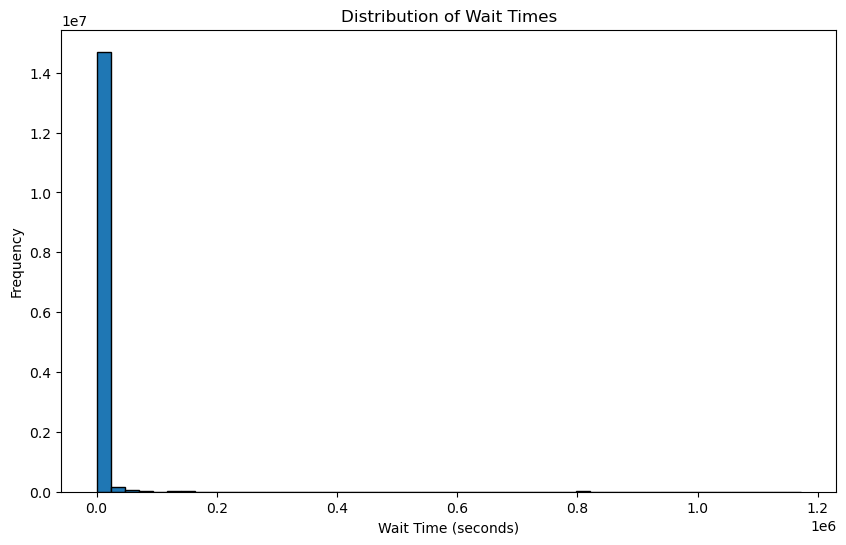

In [12]:
# Plot distribution of wait times
plt.figure(figsize=(10, 6))
plt.hist(txs['waittime'], bins=50, edgecolor='black')
plt.title('Distribution of Wait Times')
plt.xlabel('Wait Time (seconds)')
plt.ylabel('Frequency')
plt.show()

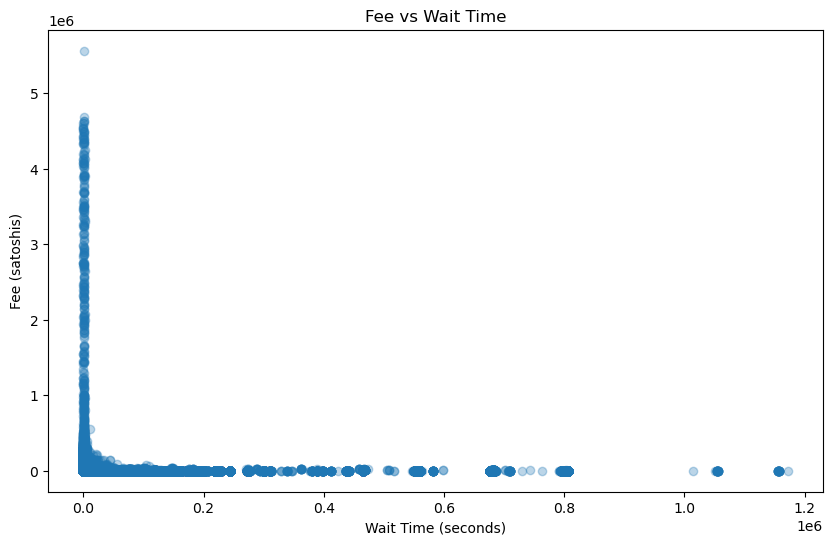

In [13]:
# Plot txs Fee vs Waittime
plt.figure(figsize=(10, 6))
plt.scatter(txs['waittime'], txs['absolute_fee'], alpha=0.3)
plt.title('Fee vs Wait Time')
plt.xlabel('Wait Time (seconds)')
plt.ylabel('Fee (satoshis)')
plt.show()

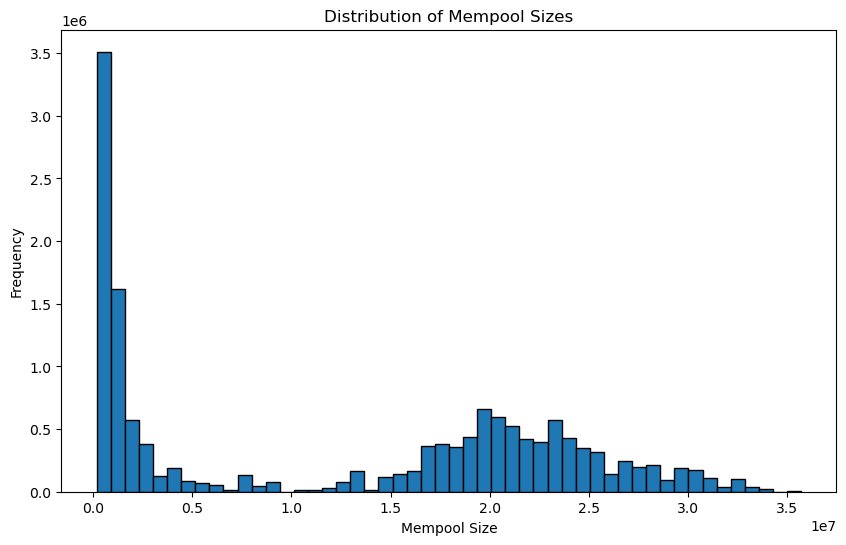

In [14]:
# Plot the distribution of mempool sizes
plt.figure(figsize=(10, 6))
plt.hist(txs['mempool_size'], bins=50, edgecolor='black')
plt.title('Distribution of Mempool Sizes')
plt.xlabel('Mempool Size')
plt.ylabel('Frequency')
plt.show()

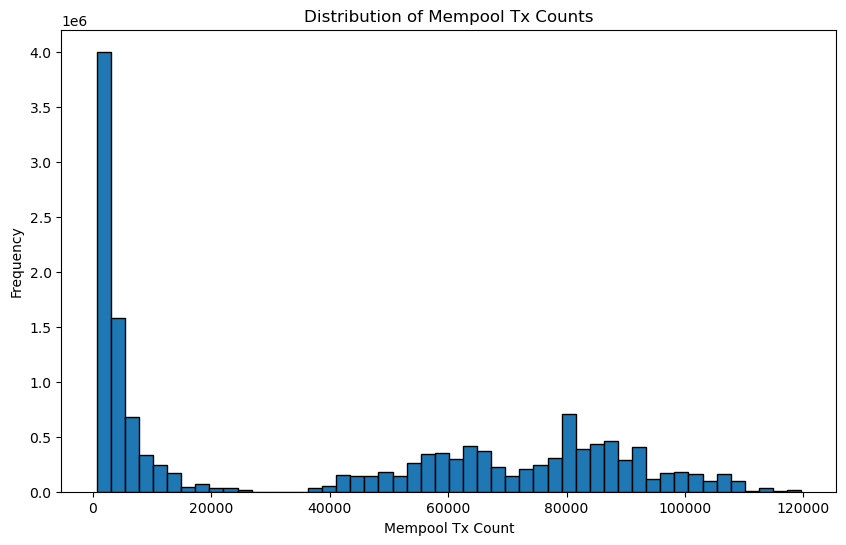

In [15]:
# Plot mempool tx count
plt.figure(figsize=(10, 6))
plt.hist(txs['mempool_tx_count'], bins=50, edgecolor='black')
plt.title('Distribution of Mempool Tx Counts')
plt.xlabel('Mempool Tx Count')
plt.ylabel('Frequency')
plt.show()


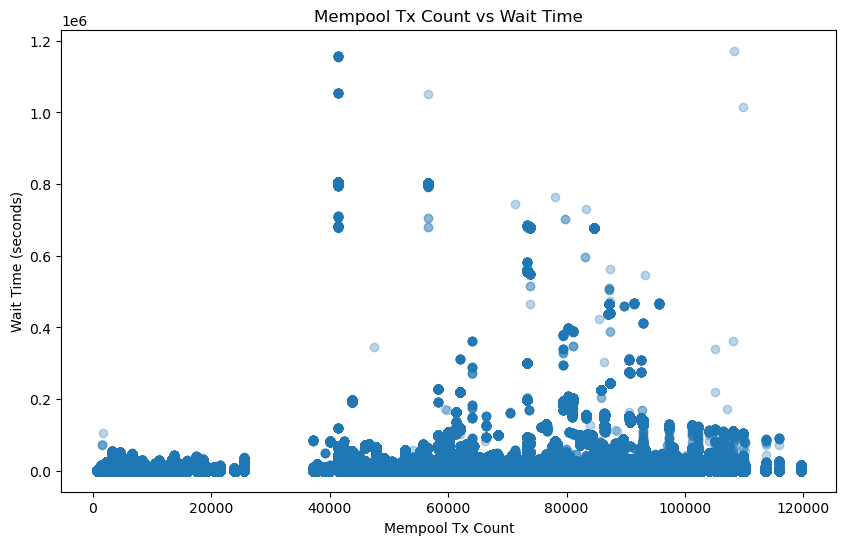

In [16]:
# Plot mempool size vs waittime
plt.figure(figsize=(10, 6))
plt.scatter(txs['mempool_tx_count'], txs['waittime'], alpha=0.3)
plt.xlabel('Mempool Tx Count')
plt.ylabel('Wait Time (seconds)')
plt.title('Mempool Tx Count vs Wait Time')
plt.show()

Train R² = 0.9038
Test R² = 0.8174


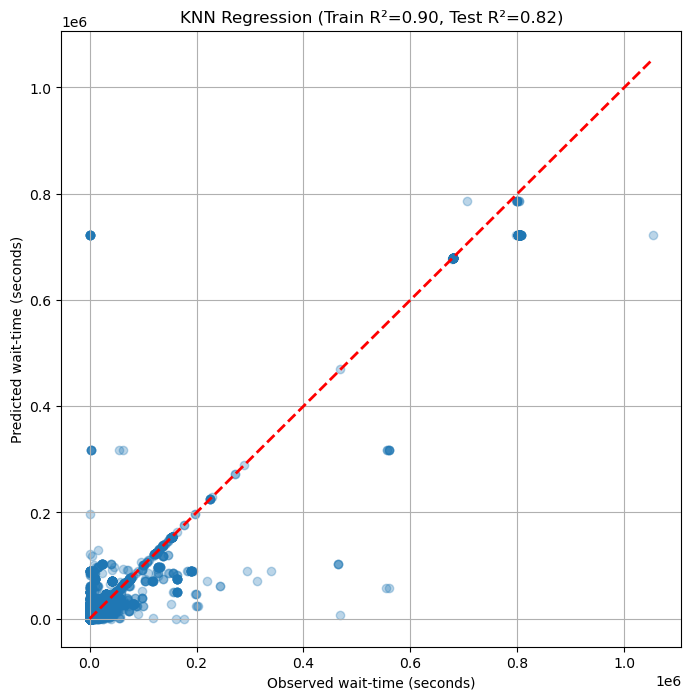

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

#Subsample to 100k rows
txs_copy = txs.copy().sample(100000, random_state=42)

# Standardize features since they're on very different scales
# Remove NaNs and ensure X and y have matching (non-NaN) rows
cols = ['mempool_tx_count', 'mempool_size', 'absolute_fee', 'waittime']
df_clean = txs_copy[cols].dropna()
X = df_clean[['mempool_tx_count', 'mempool_size', 'absolute_fee']]
y = df_clean['waittime']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Fit KNN regressor
knn = KNeighborsRegressor(n_neighbors=50, weights='distance')
knn.fit(X_train, y_train)

# Calculate R² scores
train_r2 = knn.score(X_train, y_train)
test_r2 = knn.score(X_test, y_test)
print(f"Train R² = {train_r2:.4f}")
print(f"Test R² = {test_r2:.4f}")

# Plot observed vs predicted
y_pred = knn.predict(X_scaled)
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Observed wait-time (seconds)')
plt.ylabel('Predicted wait-time (seconds)')
plt.title(f'KNN Regression (Train R²={train_r2:.2f}, Test R²={test_r2:.2f})')
plt.grid(True)
plt.show()

Test MSE: 306306560.0000


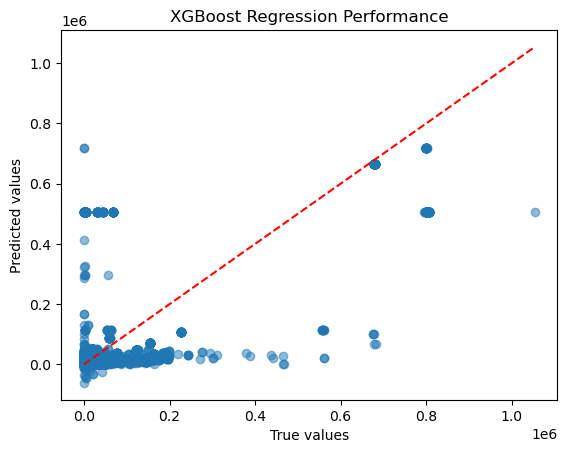

In [11]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
#Subsample to 1m rows
txs_copy = txs.copy().sample(1000000, random_state=42)
df_clean = txs_copy[cols].dropna()
X = df_clean[['mempool_tx_count', 'mempool_size', 'absolute_fee']]
y = df_clean['waittime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose=False)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("XGBoost Regression Performance")
plt.show()


Train R² = 0.0006
Test R² = 0.0007


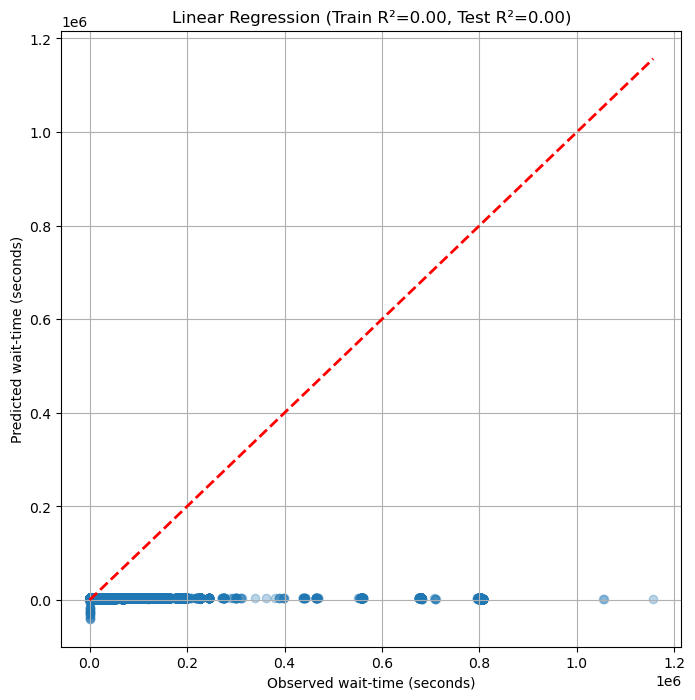

In [13]:
scaler = StandardScaler()
#sample 1m rows
txs_copy = txs.copy().sample(1000000, random_state=42)
df_clean = txs_copy[cols].dropna()
X = df_clean[['mempool_size', 'absolute_fee']]
X_scaled = scaler.fit_transform(X)
y = df_clean['waittime']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

model = LinearRegression().fit(X_train, y_train)

# Calculate R² scores
train_r2 = model.score(X_train, y_train)
test_r2 = model.score(X_test, y_test)
print(f"Train R² = {train_r2:.4f}")
print(f"Test R² = {test_r2:.4f}")

# Plot observed vs predicted
y_pred = model.predict(X_scaled)
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Observed wait-time (seconds)')
plt.ylabel('Predicted wait-time (seconds)')
plt.title(f'Linear Regression (Train R²={train_r2:.2f}, Test R²={test_r2:.2f})')
plt.grid(True)
plt.show()

Test MSE: 94259462.8549
Test R^2: 0.8907


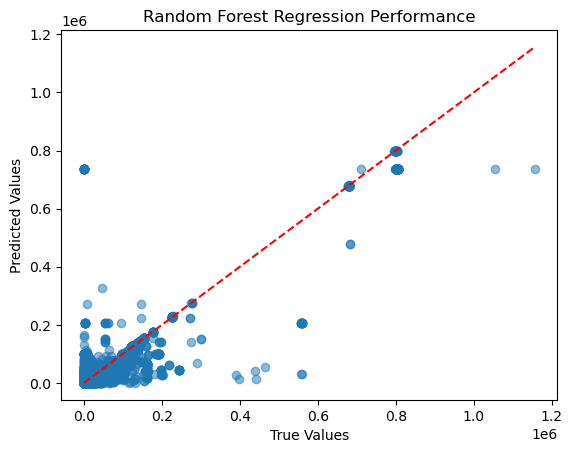

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#sample 1m rows
txs_copy = txs.copy().sample(1000000, random_state=42)
df_clean = txs_copy[cols].dropna()
X = df_clean[['mempool_tx_count', 'mempool_size', 'absolute_fee']]
y = df_clean['waittime']
# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and train Random Forest
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# 4. Predict
y_pred = model.predict(X_test)

# 5. Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test R^2: {r2:.4f}")

# 6. Optional: Plot predicted vs true
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Regression Performance")
plt.show()

# RESPEND ANALYSIS

In [3]:
# Basic respend stats using min_respend_time
has_respend = txs['min_respend_time'].notna()
respend_count = has_respend.sum()
respend_rate = has_respend.mean()

print(f"Transactions with respend: {respend_count:,} ({respend_rate:.1%})")
print(f"Transactions without respend: {(~has_respend).sum():,} ({(~has_respend).mean():.1%})")


Transactions with respend: 14,986,355 (100.0%)
Transactions without respend: 0 (0.0%)


In [4]:
# Use min_respend_time directly (already in seconds, convert to minutes)
# min_respend_time is the delay between found_at and when inputs were respent
time_to_respend = txs['min_respend_time'] / 60  # Convert seconds to minutes

# Stats for respent transactions only
respent_txs = time_to_respend[has_respend]
print(f"Time to respend stats (minutes):")
print(f"  Mean: {respent_txs.mean():.1f}")
print(f"  Median: {respent_txs.median():.1f}")
print(f"  Min: {respent_txs.min():.1f}")
print(f"  Max: {respent_txs.max():.1f}")
print(f"  Std: {respent_txs.std():.1f}")


Time to respend stats (minutes):
  Mean: 49.3
  Median: 0.1
  Min: 0.0
  Max: 13333.0
  Std: 357.9


In [5]:
# Compare wait times: respent vs not respent
waittime_respent = txs.loc[has_respend, 'waittime']
waittime_no_respend = txs.loc[~has_respend, 'waittime']

print(f"Wait time comparison (minutes):")
print(f"  Respent txs - Mean: {waittime_respent.mean()/60:.1f}, Median: {waittime_respent.median()/60:.1f}")
print(f"  No respend  - Mean: {waittime_no_respend.mean()/60:.1f}, Median: {waittime_no_respend.median()/60:.1f}")
print(f"  Difference  - Mean: {(waittime_respent.mean() - waittime_no_respend.mean())/60:.1f} min")


Wait time comparison (minutes):
  Respent txs - Mean: 55.7, Median: 8.9
  No respend  - Mean: nan, Median: nan
  Difference  - Mean: nan min


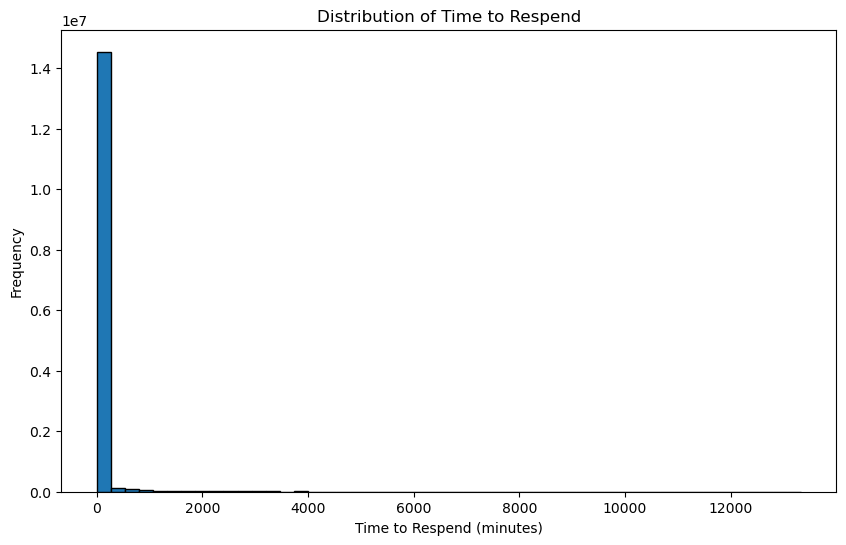

In [6]:
# Plot distribution of time to respend
plt.figure(figsize=(10, 6))
plt.hist(respent_txs, bins=50, edgecolor='black')
plt.title('Distribution of Time to Respend')
plt.xlabel('Time to Respend (minutes)')
plt.ylabel('Frequency')
plt.show()


  → Copying dataframe...
  ✓ Copy complete (65.1s)
  → Calculating respend delay...
  → Calculating time_cost...
  ✓ Time_cost calculated (66.5s)

Detailed time_cost distribution statistics:
  Count:   14,986,355
  Mean:    274562.020240
  Median:  0.333333
  Std Dev: 446293.106311
  Min:     1.250034e-06
  Max:     1.000000e+06
  1st percentile: 0.000012
  99th percentile: 1000000.000000


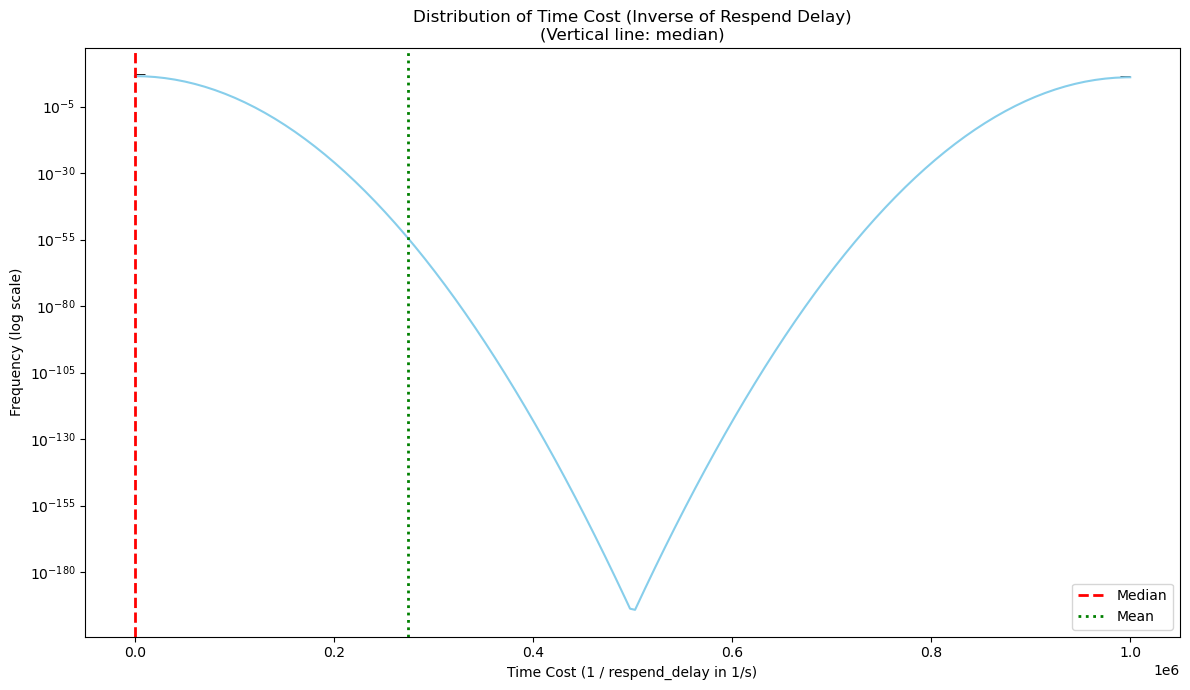

In [13]:
import time
# Time cost proxy calculation
# Calculate time_cost from min_respend_time data
start_time = time.time()
print("  → Copying dataframe...")
txs_test = txs.copy()
print(f"  ✓ Copy complete ({time.time() - start_time:.1f}s)")

# Use min_respend_time directly as respend delay (already in seconds)
print("  → Calculating respend delay...")
txs_test['respend_delay'] = txs_test['min_respend_time']

# Filter valid respends (delay >= 0 and not NaN)
valid_respend = (txs_test['respend_delay'] >= 0) & txs_test['respend_delay'].notna()

# Calculate time_cost (inverse of delay with epsilon to avoid division by zero)
print("  → Calculating time_cost...")
txs_test['time_cost'] = np.nan
txs_test.loc[valid_respend, 'time_cost'] = 1 / (txs_test.loc[valid_respend, 'respend_delay'] + 1e-6)
print(f"  ✓ Time_cost calculated ({time.time() - start_time:.1f}s)")

# Plot a detailed distribution of time_cost, with statistics and tailored visualization

import seaborn as sns

# Extract non-null time_cost values for analysis
time_cost_values = txs_test['time_cost'].dropna()

# Summary statistics
print("\nDetailed time_cost distribution statistics:")
print(f"  Count:   {len(time_cost_values):,}")
print(f"  Mean:    {time_cost_values.mean():.6f}")
print(f"  Median:  {time_cost_values.median():.6f}")
print(f"  Std Dev: {time_cost_values.std():.6f}")
print(f"  Min:     {time_cost_values.min():.6e}")
print(f"  Max:     {time_cost_values.max():.6e}")
print(f"  1st percentile: {time_cost_values.quantile(0.01):.6f}")
print(f"  99th percentile: {time_cost_values.quantile(0.99):.6f}")

plt.figure(figsize=(12, 7))
# Plot using a density-aware histogram for a better sense of distribution
sns.histplot(time_cost_values, bins=100, kde=True, log_scale=(False, True), color='skyblue', edgecolor='black', alpha=0.75)
plt.title('Distribution of Time Cost (Inverse of Respend Delay)\n(Vertical line: median)')
plt.xlabel('Time Cost (1 / respend_delay in 1/s)')
plt.ylabel('Frequency (log scale)')
plt.axvline(time_cost_values.median(), color='red', linestyle='dashed', linewidth=2, label="Median")
plt.axvline(time_cost_values.mean(), color='green', linestyle='dotted', linewidth=2, label="Mean")
plt.legend()
plt.tight_layout()
plt.show()

CPFP child txs with zero respend delay: 2873806 / 4072890 (70.559382%)
CPFP child txs with positive respend delay: 1199084 / 4072890 (29.440618%)


/var/folders/yy/9z7hdgnd0x58r37dj_z5k1kr0000gn/T/ipykernel_97473/1803459800.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), 20000), random_state=42) if len(x) > 0 else x)


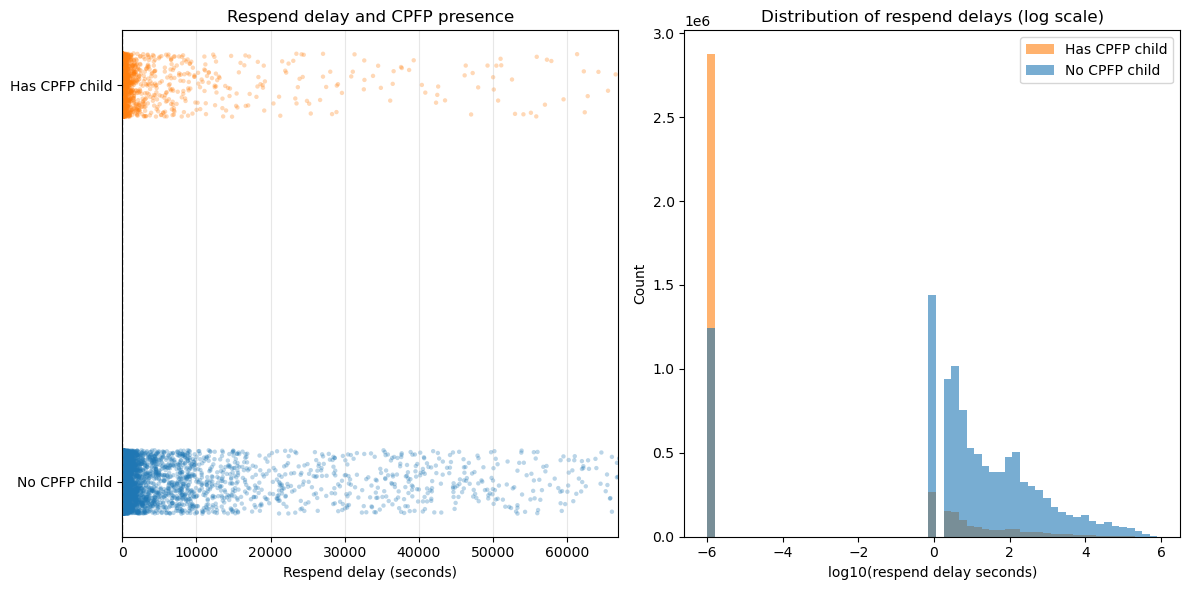

In [23]:
# Visualize respend delay for transactions with/without CPFP child transactions
import numpy as np
import matplotlib.pyplot as plt

if 'txs_test' not in globals():
    txs_test = txs.copy()
    txs_test['respend_delay'] = txs_test['min_respend_time']

plot_df = txs_test[['respend_delay', 'child_txid']].copy()
plot_df['has_child'] = plot_df['child_txid'].notna()
plot_df['respend_delay'] = plot_df['respend_delay'].fillna(0)

cpf_total = plot_df['has_child'].sum()
cpf_zero = (plot_df.loc[plot_df['has_child'], 'respend_delay'] == 0).sum()
cpf_positive = (plot_df.loc[plot_df['has_child'], 'respend_delay'] > 0).sum()
share_zero = (cpf_zero / cpf_total * 100) if cpf_total else 0.0
share_positive = (cpf_positive / cpf_total * 100) if cpf_total else 0.0
print(f"CPFP child txs with zero respend delay: {cpf_zero} / {cpf_total} ({share_zero:.6f}%)")
print(f"CPFP child txs with positive respend delay: {cpf_positive} / {cpf_total} ({share_positive:.6f}%)")

plot_df['log_delay'] = plot_df['respend_delay'].replace(0, 1e-6)
plot_df['log_delay'] = np.log10(plot_df['log_delay'])

plt.figure(figsize=(12, 6))
# Left subplot: scatter with jitter
plt.subplot(1, 2, 1)
sampled = (
    plot_df.groupby('has_child', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), 20000), random_state=42) if len(x) > 0 else x)
    .reset_index(drop=True)
)
y_jitter = np.random.uniform(-0.08, 0.08, size=len(sampled))
y_positions = sampled['has_child'].astype(int).values + y_jitter
colors = np.where(sampled['has_child'], '#ff7f0e', '#1f77b4')
plt.scatter(sampled['respend_delay'], y_positions, s=10, alpha=0.3, c=colors, edgecolors='none')
plt.yticks([0, 1], ['No CPFP child', 'Has CPFP child'])
plt.xlabel('Respend delay (seconds)')
plt.title('Respend delay and CPFP presence')
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
p99 = sampled['respend_delay'].quantile(0.99) if not sampled.empty else 1
if p99 > 0:
    plt.xlim(-0.5, p99)
plt.grid(axis='x', alpha=0.3)

# Right subplot: distribution of respend delay (log scale)
plt.subplot(1, 2, 2)
bins = np.linspace(plot_df['log_delay'].min(), plot_df['log_delay'].max(), 60)
for has_child, label, color in [(True, 'Has CPFP child', '#ff7f0e'), (False, 'No CPFP child', '#1f77b4')]:
    mask = plot_df['has_child'] == has_child
    plt.hist(plot_df.loc[mask, 'log_delay'], bins=bins, alpha=0.6, label=label, color=color)
plt.xlabel('log10(respend delay seconds)')
plt.ylabel('Count')
plt.title('Distribution of respend delays (log scale)')
plt.legend()
plt.tight_layout()
plt.show()


# MEMPOOL CONGESTION

In [14]:
# Compute mempool congestion (rho_t) for each transaction
# This requires creating epochs and computing time-weighted average congestion

EPOCH_DURATION_MINUTES = 30  # 30-minute epochs

def create_epochs(df, epoch_duration_minutes=EPOCH_DURATION_MINUTES):
    """Partition timeline into epochs"""
    start_time = df['found_at'].min()
    end_time = df['found_at'].max()
    
    epoch_seconds = epoch_duration_minutes * 60
    num_epochs = int(np.ceil((end_time - start_time) / epoch_seconds))
    
    bins = np.linspace(start_time, start_time + (num_epochs * epoch_seconds), num_epochs + 1)
    df['epoch'] = pd.cut(df['found_at'], bins=bins, labels=False, include_lowest=True)
    
    print(f"✓ Created {num_epochs} epochs of {epoch_duration_minutes} minutes each")
    return df

def compute_mempool_congestion(df):
    """Compute mempool congestion (ρ̂t) using event-based simulation"""
    print("Computing mempool congestion...")
    
    # 1. Create entry and exit events
    entries = df[['found_at']].copy()
    entries['change'] = 1
    entries.rename(columns={'found_at': 'time'}, inplace=True)
    
    mined_exits = df.loc[df['mined_at'].notna(), ['mined_at']].copy()
    mined_exits['change'] = -1
    mined_exits.rename(columns={'mined_at': 'time'}, inplace=True)
    
    pruned_exits = df.loc[df['pruned_at'].notna(), ['pruned_at']].copy()
    pruned_exits['change'] = -1
    pruned_exits.rename(columns={'pruned_at': 'time'}, inplace=True)
    
    events = pd.concat([entries, mined_exits, pruned_exits]).dropna(subset=['time'])
    events_grouped = events.groupby('time')['change'].sum().reset_index()
    events_grouped.sort_values(by='time', inplace=True)
    
    # 2. Initial congestion estimate
    first_tx = df.sort_values(by='found_at').iloc[0]
    initial_congestion = first_tx['mempool_tx_count']
    
    # 3. Running congestion count
    events_grouped['congestion'] = events_grouped['change'].cumsum() + initial_congestion
    
    # 4. Time-weighted average congestion per epoch
    epoch_duration_seconds = EPOCH_DURATION_MINUTES * 60
    start_time = df['found_at'].min()
    end_time = df['found_at'].max()
    num_epochs = int(np.ceil((end_time - start_time) / epoch_duration_seconds))
    epoch_bins = np.linspace(start_time, start_time + (num_epochs * epoch_duration_seconds), num_epochs + 1)
    
    epoch_avg_congestion = []
    
    for i in range(num_epochs):
        epoch_start = epoch_bins[i]
        epoch_end = epoch_bins[i+1]
        
        epoch_events = events_grouped[
            (events_grouped['time'] >= epoch_start) & (events_grouped['time'] < epoch_end)
        ]
        
        last_event_before = events_grouped[events_grouped['time'] < epoch_start].tail(1)
        if not last_event_before.empty:
            congestion_at_epoch_start = last_event_before['congestion'].iloc[0]
        else:
            congestion_at_epoch_start = initial_congestion
        
        total_weighted_congestion = 0
        current_time = epoch_start
        current_congestion = congestion_at_epoch_start
        
        for _, event in epoch_events.iterrows():
            event_time = event['time']
            duration = event_time - current_time
            total_weighted_congestion += current_congestion * duration
            
            current_time = event_time
            current_congestion = event['congestion']
        
        duration = epoch_end - current_time
        total_weighted_congestion += current_congestion * duration
        
        total_duration = epoch_end - epoch_start
        avg_congestion = total_weighted_congestion / total_duration if total_duration > 0 else current_congestion
        epoch_avg_congestion.append({'epoch': i, 'rho_t': avg_congestion})
    
    congestion_df = pd.DataFrame(epoch_avg_congestion)
    df = df.merge(congestion_df, on='epoch', how='left')
    
    print(f"✓ Computed congestion for {len(congestion_df)} epochs")
    return df

# Apply to our test dataset
txs_with_congestion = txs_test.copy()
txs_with_congestion = create_epochs(txs_with_congestion)
txs_with_congestion = compute_mempool_congestion(txs_with_congestion)

print(f"\n✓ Congestion stats:")
print(f"  Mean: {txs_with_congestion['rho_t'].mean():,.0f} transactions")
print(f"  Median: {txs_with_congestion['rho_t'].median():,.0f} transactions")
print(f"  Min: {txs_with_congestion['rho_t'].min():,.0f}, Max: {txs_with_congestion['rho_t'].max():,.0f}")

✓ Created 3245 epochs of 30 minutes each
Computing mempool congestion...
✓ Computed congestion for 3245 epochs

✓ Congestion stats:
  Mean: 20,813 transactions
  Median: 14,248 transactions
  Min: 4,610, Max: 73,589


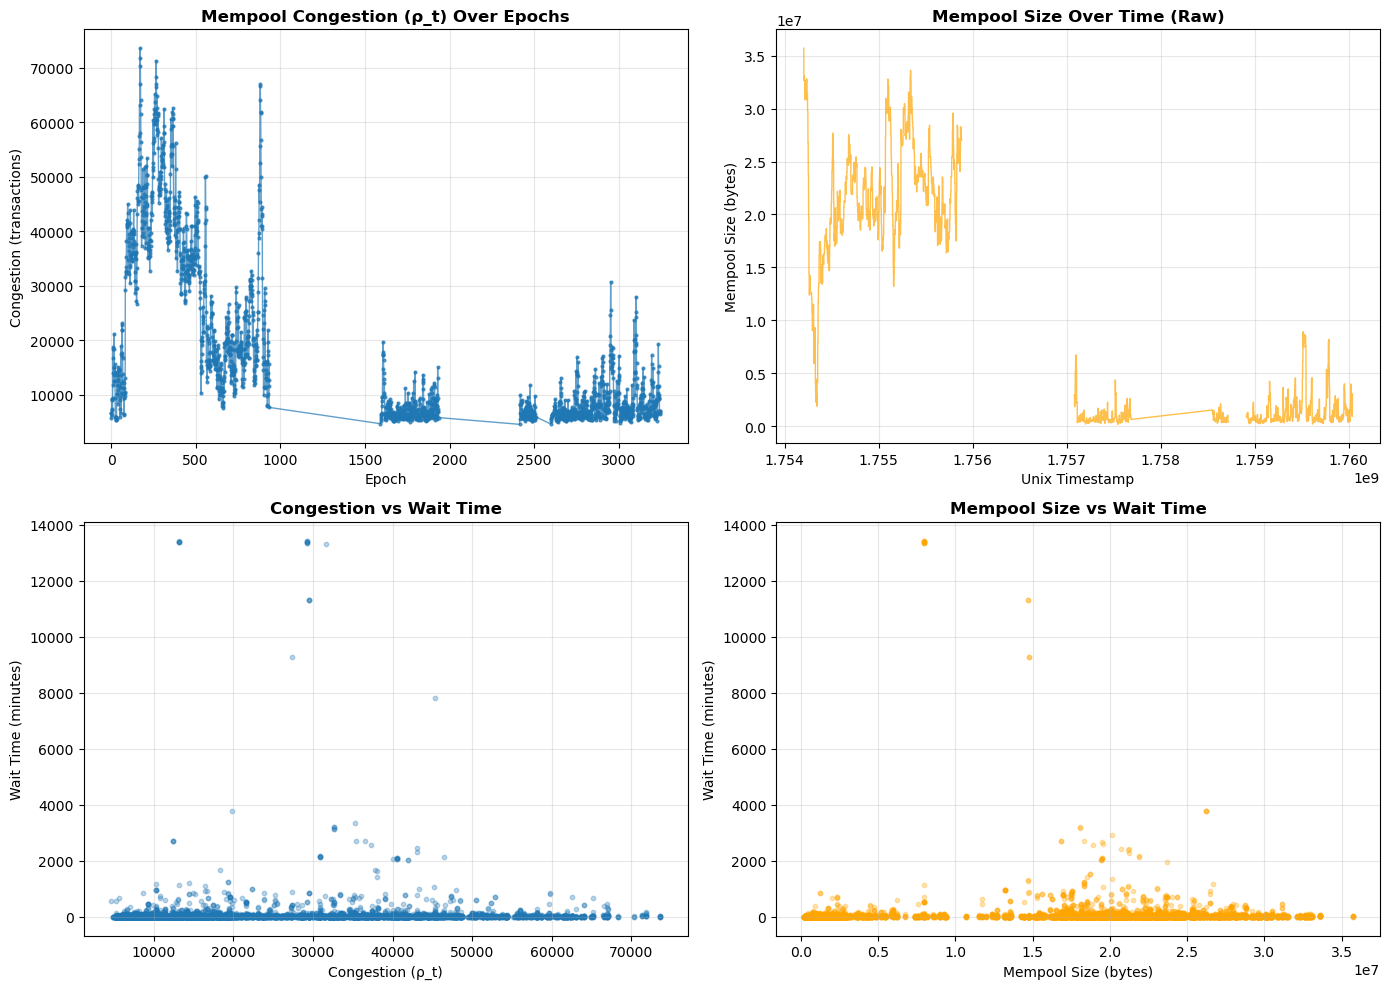

In [25]:
# Visualize: Congestion (rho_t) vs Mempool Size comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Congestion over time
epoch_rho = txs_with_congestion[['epoch', 'rho_t']].drop_duplicates().sort_values('epoch')
axes[0, 0].plot(epoch_rho['epoch'], epoch_rho['rho_t'], marker='o', markersize=2, linewidth=1, alpha=0.7)
axes[0, 0].set_title('Mempool Congestion (ρ_t) Over Epochs', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Congestion (transactions)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Mempool size over time (for comparison)
time_sorted = txs_with_congestion.sort_values('found_at')[['found_at', 'mempool_size']].iloc[::1000]  # Sample
axes[0, 1].plot(time_sorted['found_at'], time_sorted['mempool_size'], linewidth=1, alpha=0.7, color='orange')
axes[0, 1].set_title('Mempool Size Over Time (Raw)', fontweight='bold')
axes[0, 1].set_xlabel('Unix Timestamp')
axes[0, 1].set_ylabel('Mempool Size (bytes)')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Congestion vs Waittime
sample = txs_with_congestion[['rho_t', 'waittime']].dropna().sample(min(10000, len(txs_with_congestion)), random_state=42)
axes[1, 0].scatter(sample['rho_t'], sample['waittime']/60, alpha=0.3, s=10)
axes[1, 0].set_title('Congestion vs Wait Time', fontweight='bold')
axes[1, 0].set_xlabel('Congestion (ρ_t)')
axes[1, 0].set_ylabel('Wait Time (minutes)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Mempool Size vs Waittime (for comparison)
sample2 = txs_with_congestion[['mempool_size', 'waittime']].dropna().sample(min(10000, len(txs_with_congestion)), random_state=42)
axes[1, 1].scatter(sample2['mempool_size'], sample2['waittime']/60, alpha=0.3, s=10, color='orange')
axes[1, 1].set_title('Mempool Size vs Wait Time', fontweight='bold')
axes[1, 1].set_xlabel('Mempool Size (bytes)')
axes[1, 1].set_ylabel('Wait Time (minutes)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


DATA GAP ANALYSIS

Time difference statistics (seconds):
  Mean:   0.54
  Median: 0.00
  Std:    447.08
  95th percentile: 1.00
  99th percentile: 3.00

GAPS IDENTIFIED (threshold: 1.0 hours)

Total gaps found: 3

Gap #    Start                     End                       Duration (hours)   Duration (days)
--------------------------------------------------------------------------------------------------------------
1        2025-08-22 17:49:10       2025-09-05 10:41:10       328.87             13.70          
2        2025-09-12 14:14:41       2025-09-22 13:56:29       239.70             9.99           
3        2025-09-24 12:56:42       2025-09-26 10:20:25       45.40              1.89           

GAP SUMMARY STATISTICS
Total data collection gaps: 3
Total time lost to gaps:    613.96 hours (25.58 days)
Average gap duration:       204.65 hours (8.53 days)
Longest gap:                328.87 hours (13.70 days)
Shortest gap:               45.40 hours (1.89 days)

DATA COMPLETENESS
Total

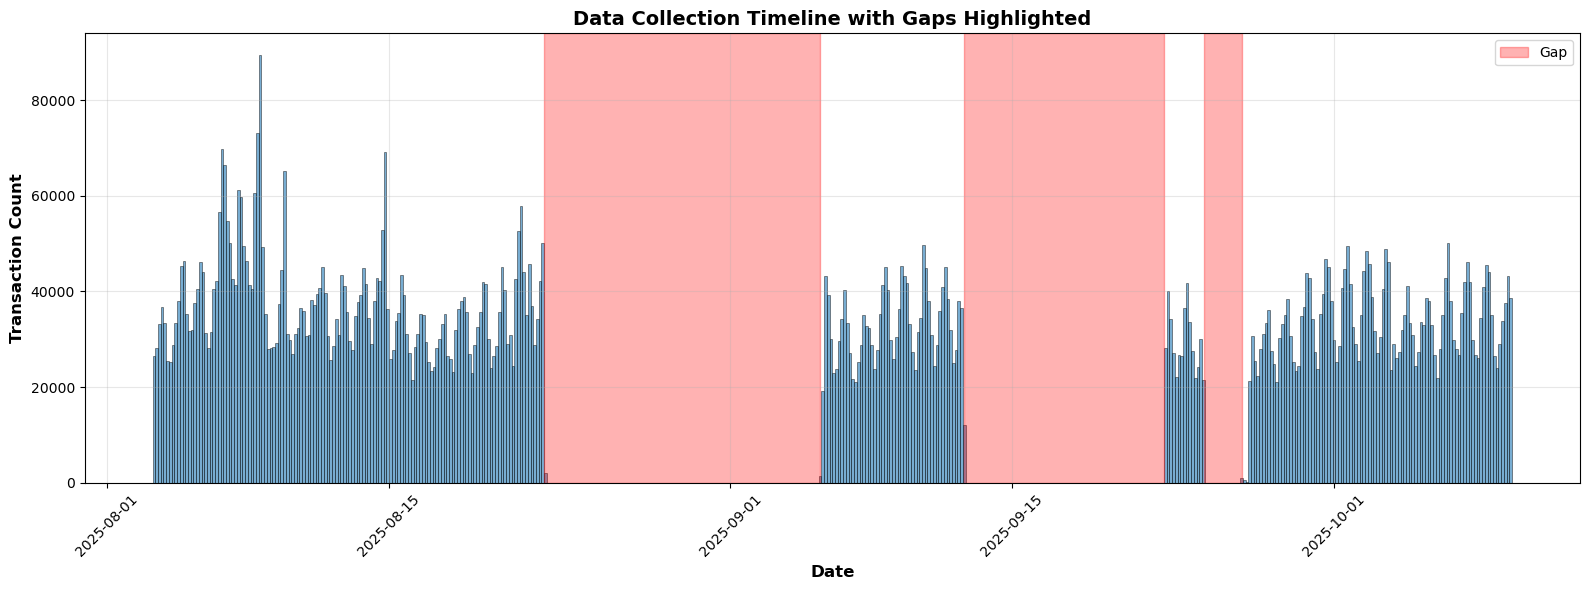

In [16]:
# DATA GAP ANALYSIS
# Identify gaps in data collection

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

print("=" * 80)
print("DATA GAP ANALYSIS")
print("=" * 80)

# Sort by found_at to analyze temporal gaps
df_sorted = txs_with_congestion.sort_values('found_at').copy()

# Calculate time differences between consecutive transactions
df_sorted['time_diff'] = df_sorted['found_at'].diff()

# Get statistics on typical intervals
print(f"\nTime difference statistics (seconds):")
print(f"  Mean:   {df_sorted['time_diff'].mean():.2f}")
print(f"  Median: {df_sorted['time_diff'].median():.2f}")
print(f"  Std:    {df_sorted['time_diff'].std():.2f}")
print(f"  95th percentile: {df_sorted['time_diff'].quantile(0.95):.2f}")
print(f"  99th percentile: {df_sorted['time_diff'].quantile(0.99):.2f}")

# Define a gap as any interval > 1 hour (3600 seconds)
# This is well above the 99th percentile of normal intervals
GAP_THRESHOLD_SECONDS = 3600  # 1 hour
GAP_THRESHOLD_HOURS = GAP_THRESHOLD_SECONDS / 3600

# Find all gaps
gaps = df_sorted[df_sorted['time_diff'] > GAP_THRESHOLD_SECONDS].copy()

print(f"\n" + "=" * 80)
print(f"GAPS IDENTIFIED (threshold: {GAP_THRESHOLD_HOURS:.1f} hours)")
print("=" * 80)
print(f"\nTotal gaps found: {len(gaps)}")

if len(gaps) > 0:
    # For each gap, find the start and end times
    gap_details = []
    
    for idx, row in gaps.iterrows():
        gap_duration_hours = row['time_diff'] / 3600
        gap_duration_days = gap_duration_hours / 24
        
        # Find the index of the previous transaction
        prev_idx = df_sorted.index[df_sorted.index.get_loc(idx) - 1]
        prev_timestamp = df_sorted.loc[prev_idx, 'found_at']
        curr_timestamp = row['found_at']
        
        gap_details.append({
            'gap_start': prev_timestamp,
            'gap_end': curr_timestamp,
            'duration_hours': gap_duration_hours,
            'duration_days': gap_duration_days,
            'gap_start_datetime': pd.to_datetime(prev_timestamp, unit='s'),
            'gap_end_datetime': pd.to_datetime(curr_timestamp, unit='s')
        })
    
    gap_df = pd.DataFrame(gap_details)
    
    print(f"\n{'Gap #':<8} {'Start':<25} {'End':<25} {'Duration (hours)':<18} {'Duration (days)':<15}")
    print("-" * 110)
    
    for i, row in gap_df.iterrows():
        print(f"{i+1:<8} {str(row['gap_start_datetime']):<25} {str(row['gap_end_datetime']):<25} "
              f"{row['duration_hours']:<18.2f} {row['duration_days']:<15.2f}")
    
    # Summary statistics
    print(f"\n" + "=" * 80)
    print("GAP SUMMARY STATISTICS")
    print("=" * 80)
    print(f"Total data collection gaps: {len(gap_df)}")
    print(f"Total time lost to gaps:    {gap_df['duration_hours'].sum():.2f} hours ({gap_df['duration_days'].sum():.2f} days)")
    print(f"Average gap duration:       {gap_df['duration_hours'].mean():.2f} hours ({gap_df['duration_days'].mean():.2f} days)")
    print(f"Longest gap:                {gap_df['duration_hours'].max():.2f} hours ({gap_df['duration_days'].max():.2f} days)")
    print(f"Shortest gap:               {gap_df['duration_hours'].min():.2f} hours ({gap_df['duration_days'].min():.2f} days)")
    
    # Calculate data completeness
    total_time_span = df_sorted['found_at'].max() - df_sorted['found_at'].min()
    total_gap_time = gap_df['duration_hours'].sum() * 3600  # Convert back to seconds
    data_completeness = (total_time_span - total_gap_time) / total_time_span * 100
    
    print(f"\n" + "=" * 80)
    print("DATA COMPLETENESS")
    print("=" * 80)
    print(f"Total time span:      {total_time_span / 86400:.2f} days")
    print(f"Time with data:       {(total_time_span - total_gap_time) / 86400:.2f} days")
    print(f"Time in gaps:         {total_gap_time / 86400:.2f} days")
    print(f"Data completeness:    {data_completeness:.2f}%")
    
    # Check if gaps are consistent across all metrics
    print(f"\n" + "=" * 80)
    print("GAP CONSISTENCY CHECK")
    print("=" * 80)
    print("Checking if gaps affect all data columns equally...")
    
    # For each gap period, check if we have ANY data
    for i, row in gap_df.iterrows():
        gap_start = row['gap_start']
        gap_end = row['gap_end']
        
        # Check if any transactions exist in this gap period
        txs_in_gap = txs[(txs['found_at'] > gap_start) & (txs['found_at'] < gap_end)]
        
        print(f"\nGap #{i+1} ({row['gap_start_datetime']} to {row['gap_end_datetime']}):")
        print(f"  Transactions found in gap: {len(txs_in_gap)}")
        
        if len(txs_in_gap) > 0:
            print(f"  ⚠️  WARNING: This gap is NOT consistent across all data!")
            print(f"  Some transactions exist but were not included in analysis.")
        else:
            print(f"  ✓ Gap is consistent - no data collected during this period")
    
    # Visualize gaps on timeline
    print(f"\n" + "=" * 80)
    print("VISUALIZING GAPS")
    print("=" * 80)
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot all timestamps as a histogram
    timestamps = pd.to_datetime(df_sorted['found_at'], unit='s')
    ax.hist(timestamps, bins=500, alpha=0.6, edgecolor='black', linewidth=0.5)
    
    # Highlight gap periods with red vertical spans
    for i, row in gap_df.iterrows():
        ax.axvspan(row['gap_start_datetime'], row['gap_end_datetime'], 
                   alpha=0.3, color='red', label='Gap' if i == 0 else '')
    
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Transaction Count', fontsize=12, fontweight='bold')
    ax.set_title('Data Collection Timeline with Gaps Highlighted', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
else:
    print("\n✓ No significant gaps found in data collection!")

print(f"\n" + "=" * 80)

Filtering data to before first gap: 2025-08-22 17:49:10
Original data size: 5,404,367 transactions
Filtered data size: 5,404,367 transactions
Test MSE (log scale): 1.2469
Test R^2 (log scale): 0.3537

=== FEATURE IMPORTANCE ===
  log_rho_t                : 0.5203
  log_time_cost            : 0.4457
  has_child                : 0.0285
  rbf_flag                 : 0.0055


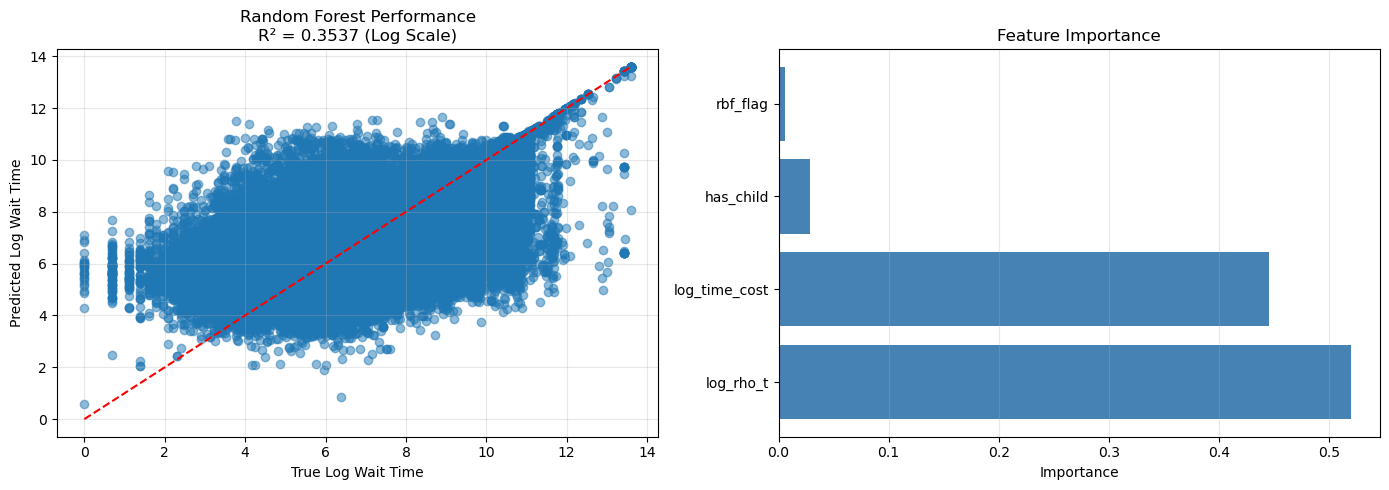

In [36]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

# Filter to only include data from the first continuous chunk (before first gap)
# Gap starts at 2025-08-22 17:49:10
first_gap_start = pd.Timestamp('2025-08-22 17:49:10').timestamp()
print(f"Filtering data to before first gap: {pd.to_datetime(first_gap_start, unit='s')}")
print(f"Original data size: {len(txs_with_congestion):,} transactions")

txs_with_congestion = txs_with_congestion[txs_with_congestion['found_at'] < first_gap_start].copy()
print(f"Filtered data size: {len(txs_with_congestion):,} transactions")

#txs_with_congestion = txs_with_congestion[txs_with_congestion['respend_delay'] > 0]
txs_with_congestion['has_child'] = txs_with_congestion['child_txid'].notna().astype(int)
txs_with_congestion['rbf_flag'] = txs['rbf_fee_total'].notna().astype(int)

#sample 2m rows (or all if less than 2m)
sample_size = min(2000000, len(txs_with_congestion))
txs_copy = txs_with_congestion.copy().sample(sample_size, random_state=42)
df_clean = txs_copy[['mempool_tx_count', 'rho_t', 'time_cost', 'has_child', 'rbf_flag', 'waittime']].dropna()

# Log transform features to improve model performance
df_clean['log_mempool_tx_count'] = np.log1p(df_clean['mempool_tx_count'])
df_clean['log_rho_t'] = np.log1p(df_clean['rho_t'])
df_clean['log_time_cost'] = np.log1p(df_clean['time_cost'])
# has_child is already binary (0/1), so no log transform needed
df_clean['log_waittime'] = np.log1p(df_clean['waittime'])

valid_idx = df_clean.notna().all(axis=1) & df_clean['waittime'].notna()

df_clean = df_clean[valid_idx]
X = df_clean[['log_rho_t', 'log_time_cost', 'has_child', 'rbf_flag']]
y = df_clean['log_waittime']
# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and train Random Forest
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-2
)
model.fit(X_train, y_train)

# 4. Predict
y_pred = model.predict(X_test)

# 5. Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE (log scale): {mse:.4f}")
print(f"Test R^2 (log scale): {r2:.4f}")

# 6. Feature Importance
feature_names = ['log_rho_t', 'log_time_cost', 'has_child', 'rbf_flag']
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(f"\n=== FEATURE IMPORTANCE ===")
for idx, row in feature_importance_df.iterrows():
    print(f"  {row['feature']:25s}: {row['importance']:.4f}")

# 7. Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predicted vs True (in log scale)
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel("True Log Wait Time")
axes[0].set_ylabel("Predicted Log Wait Time")
axes[0].set_title(f"Random Forest Performance\nR² = {r2:.4f} (Log Scale)")
axes[0].grid(True, alpha=0.3)

# Plot 2: Feature Importance
axes[1].barh(feature_importance_df['feature'], feature_importance_df['importance'], color='steelblue')
axes[1].set_xlabel('Importance')
axes[1].set_title('Feature Importance')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

COMPREHENSIVE MODEL EVALUATION

📊 REGRESSION METRICS (Log Scale):
  R² Score:                    0.3537
  Explained Variance:          0.3537
  Root Mean Squared Error:     1.1166
  Mean Absolute Error:         0.8236
  Median Absolute Error:       0.6204
  Mean Absolute % Error:       inf%

⏱️  METRICS IN ORIGINAL SCALE (seconds):
  RMSE:                        7146.74 seconds (119.11 minutes)
  MAE:                         1089.45 seconds (18.16 minutes)
  Median Absolute Error:       273.52 seconds (4.56 minutes)

📈 ERROR DISTRIBUTION (seconds):
  50th percentile (median):    273.52 seconds (4.56 min)
  75th percentile:             640.60 seconds (10.68 min)
  90th percentile:             1636.60 seconds (27.28 min)
  95th percentile:             3441.86 seconds (57.36 min)
  99th percentile:             15891.23 seconds (264.85 min)

🎯 PREDICTION ACCURACY:
  Within ±1 minute:            13.47%
  Within ±5 minutes:           52.95%
  Within ±10 minutes:          73.34%
  Within ±30 

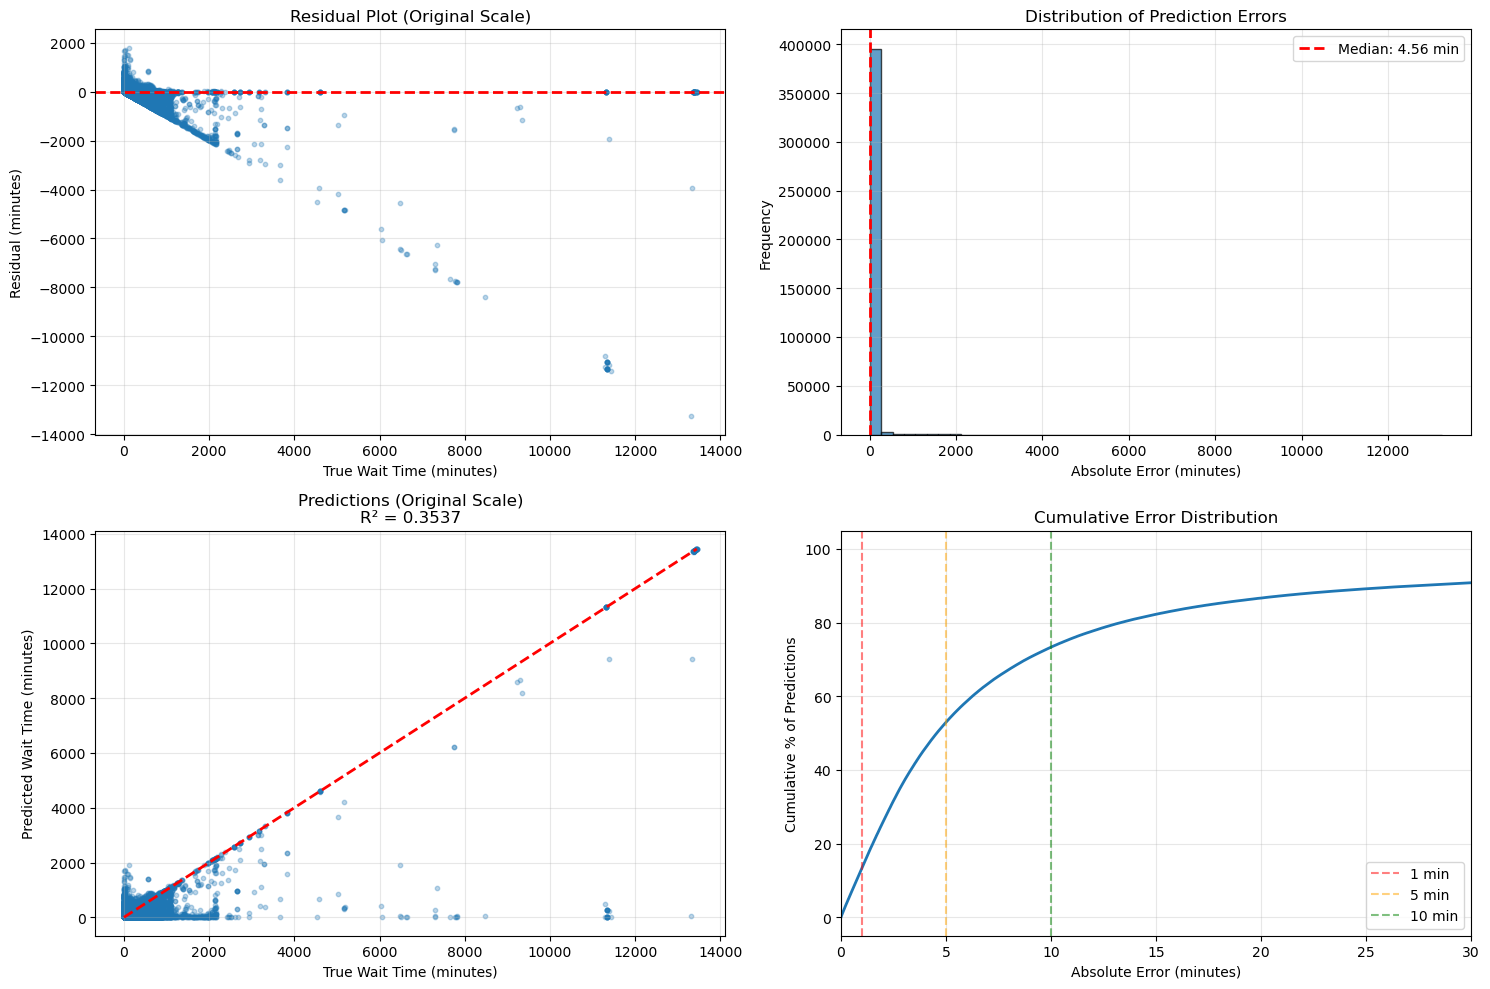

In [37]:
# ADDITIONAL EVALUATION METRICS FOR CURRENT MODEL
# More ways to assess predictive power

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score

print("=" * 80)
print("COMPREHENSIVE MODEL EVALUATION")
print("=" * 80)

# Basic metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
explained_var = explained_variance_score(y_test, y_pred)

print(f"\n📊 REGRESSION METRICS (Log Scale):")
print(f"  R² Score:                    {r2:.4f}")
print(f"  Explained Variance:          {explained_var:.4f}")
print(f"  Root Mean Squared Error:     {rmse:.4f}")
print(f"  Mean Absolute Error:         {mae:.4f}")
print(f"  Median Absolute Error:       {median_ae:.4f}")
print(f"  Mean Absolute % Error:       {mape:.2f}%")

# Convert back from log scale for interpretability
y_test_actual = np.expm1(y_test)  # inverse of log1p
y_pred_actual = np.expm1(y_pred)

rmse_actual = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae_actual = mean_absolute_error(y_test_actual, y_pred_actual)
median_ae_actual = median_absolute_error(y_test_actual, y_pred_actual)

print(f"\n⏱️  METRICS IN ORIGINAL SCALE (seconds):")
print(f"  RMSE:                        {rmse_actual:.2f} seconds ({rmse_actual/60:.2f} minutes)")
print(f"  MAE:                         {mae_actual:.2f} seconds ({mae_actual/60:.2f} minutes)")
print(f"  Median Absolute Error:       {median_ae_actual:.2f} seconds ({median_ae_actual/60:.2f} minutes)")

# Error percentiles
errors = np.abs(y_test_actual - y_pred_actual)
print(f"\n📈 ERROR DISTRIBUTION (seconds):")
print(f"  50th percentile (median):    {np.percentile(errors, 50):.2f} seconds ({np.percentile(errors, 50)/60:.2f} min)")
print(f"  75th percentile:             {np.percentile(errors, 75):.2f} seconds ({np.percentile(errors, 75)/60:.2f} min)")
print(f"  90th percentile:             {np.percentile(errors, 90):.2f} seconds ({np.percentile(errors, 90)/60:.2f} min)")
print(f"  95th percentile:             {np.percentile(errors, 95):.2f} seconds ({np.percentile(errors, 95)/60:.2f} min)")
print(f"  99th percentile:             {np.percentile(errors, 99):.2f} seconds ({np.percentile(errors, 99)/60:.2f} min)")

# Prediction accuracy within time windows
within_1_min = (errors <= 60).mean() * 100
within_5_min = (errors <= 300).mean() * 100
within_10_min = (errors <= 600).mean() * 100
within_30_min = (errors <= 1800).mean() * 100

print(f"\n🎯 PREDICTION ACCURACY:")
print(f"  Within ±1 minute:            {within_1_min:.2f}%")
print(f"  Within ±5 minutes:           {within_5_min:.2f}%")
print(f"  Within ±10 minutes:          {within_10_min:.2f}%")
print(f"  Within ±30 minutes:          {within_30_min:.2f}%")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Residuals
residuals = y_pred_actual - y_test_actual
axes[0, 0].scatter(y_test_actual/60, residuals/60, alpha=0.3, s=10)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('True Wait Time (minutes)')
axes[0, 0].set_ylabel('Residual (minutes)')
axes[0, 0].set_title('Residual Plot (Original Scale)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Error Distribution
axes[0, 1].hist(errors/60, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Absolute Error (minutes)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Prediction Errors')
axes[0, 1].axvline(median_ae_actual/60, color='r', linestyle='--', linewidth=2, label=f'Median: {median_ae_actual/60:.2f} min')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Predicted vs Actual (Original Scale)
axes[1, 0].scatter(y_test_actual/60, y_pred_actual/60, alpha=0.3, s=10)
axes[1, 0].plot([y_test_actual.min()/60, y_test_actual.max()/60], 
                [y_test_actual.min()/60, y_test_actual.max()/60], 'r--', lw=2)
axes[1, 0].set_xlabel('True Wait Time (minutes)')
axes[1, 0].set_ylabel('Predicted Wait Time (minutes)')
axes[1, 0].set_title(f'Predictions (Original Scale)\nR² = {r2:.4f}')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Cumulative Error Distribution
sorted_errors = np.sort(errors/60)
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
axes[1, 1].plot(sorted_errors, cumulative, linewidth=2)
axes[1, 1].axvline(1, color='r', linestyle='--', alpha=0.5, label='1 min')
axes[1, 1].axvline(5, color='orange', linestyle='--', alpha=0.5, label='5 min')
axes[1, 1].axvline(10, color='green', linestyle='--', alpha=0.5, label='10 min')
axes[1, 1].set_xlabel('Absolute Error (minutes)')
axes[1, 1].set_ylabel('Cumulative % of Predictions')
axes[1, 1].set_title('Cumulative Error Distribution')
axes[1, 1].set_xlim(0, 30)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)


MODEL COMPARISON - Multiple Regressors & Metrics

Checking data types...
X_train dtypes:
log_rho_t        float64
log_time_cost    float64
has_child          int64
rbf_flag         float64
dtype: object
✓ All columns are numeric


Training Random Forest...
  ✓ R² = 0.3537, RMSE = 1.1166, MAE = 0.8236, Time = 95.9s

Training Gradient Boosting...
  ✓ R² = 0.1516, RMSE = 1.2793, MAE = 0.9856, Time = 97.2s

Training XGBoost...
  ✓ R² = 0.1171, RMSE = 1.3051, MAE = 1.0074, Time = 1.5s

Training Extra Trees...
  ✓ R² = 0.3092, RMSE = 1.1544, MAE = 0.8434, Time = 52.2s

Training Neural Network...
  ✓ R² = 0.0616, RMSE = 1.3455, MAE = 1.0352, Time = 105.8s

RESULTS SUMMARY (sorted by R²)
            Model       R²     RMSE      MAE  Median AE  MAPE (%)  Train Time (s)
    Random Forest 0.353666 1.116634 0.823572   0.620389       inf       95.942649
      Extra Trees 0.309242 1.154371 0.843402   0.627247       inf       52.171674
Gradient Boosting 0.151586 1.279341 0.985602   0.788632       inf

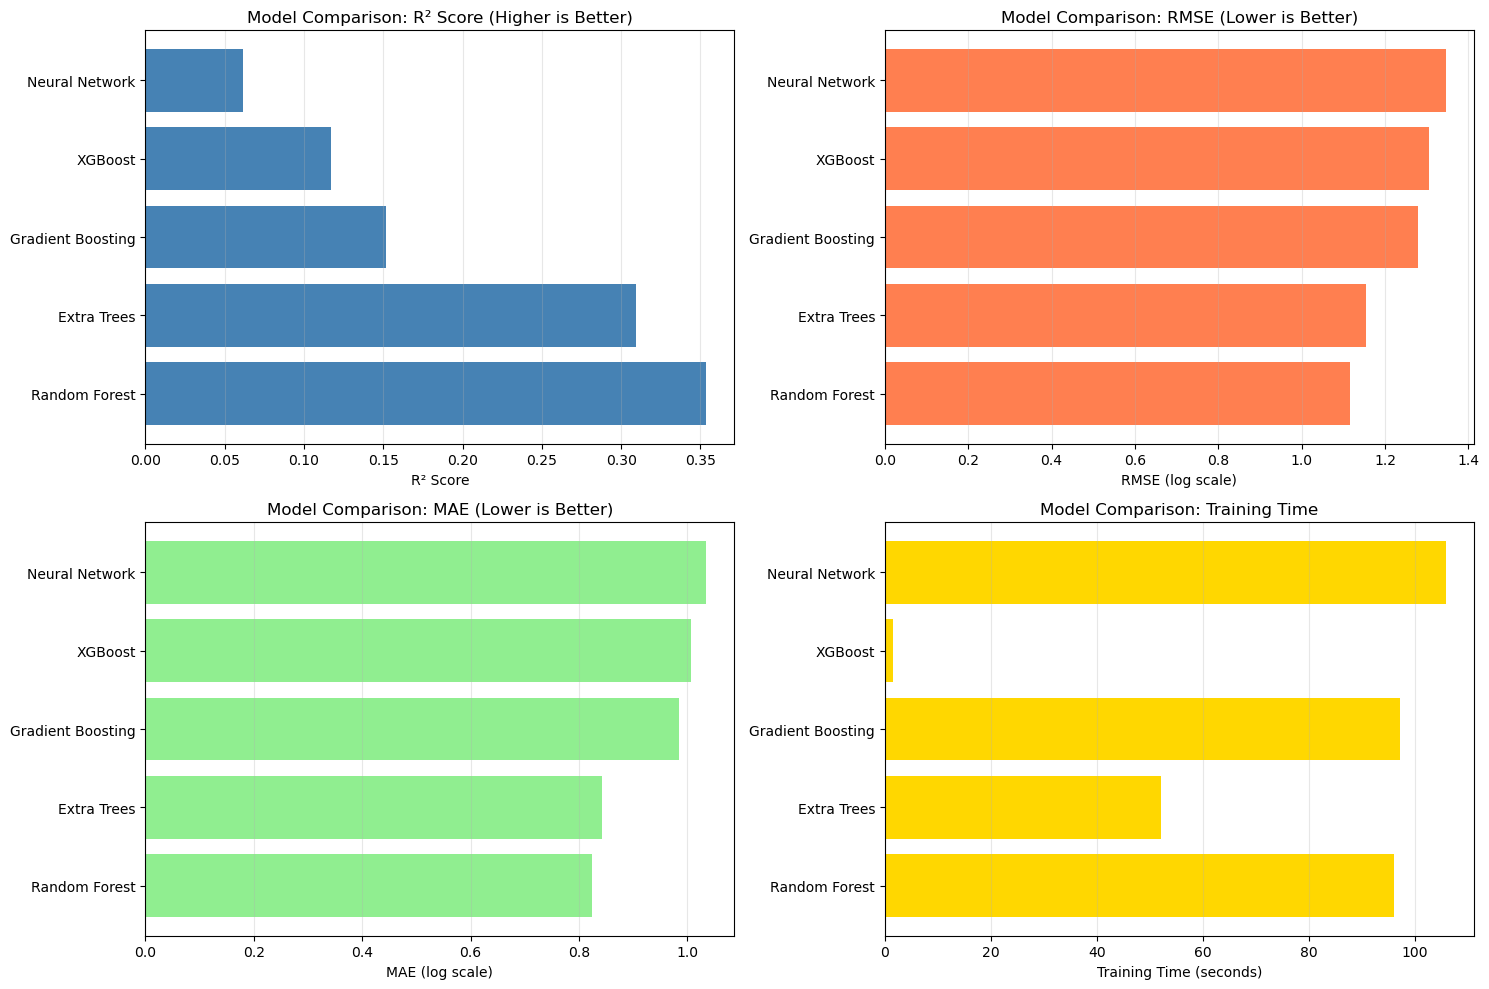


METRIC EXPLANATIONS
• R²: Proportion of variance explained (0-1, higher is better)
• RMSE: Root Mean Squared Error - penalizes large errors more
• MAE: Mean Absolute Error - average absolute difference
• Median AE: Median Absolute Error - robust to outliers
• MAPE: Mean Absolute Percentage Error - relative error %


In [38]:
# COMPREHENSIVE MODEL COMPARISON
# Test multiple regressors with multiple evaluation metrics

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
import xgboost as xgb
import time

print("=" * 80)
print("MODEL COMPARISON - Multiple Regressors & Metrics")
print("=" * 80)

# Use the same train/test split from above
# X_train, X_test, y_train, y_test are already defined

# Ensure all columns are numeric (convert boolean/object to int)
print("\nChecking data types...")
print(f"X_train dtypes:\n{X_train.dtypes}")

# Make copies and ensure all columns are numeric
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

for col in X_train_clean.columns:
    if X_train_clean[col].dtype == 'object' or X_train_clean[col].dtype == 'bool':
        X_train_clean[col] = X_train_clean[col].astype(int)
        X_test_clean[col] = X_test_clean[col].astype(int)
        print(f"  Converted {col} to int")

print("✓ All columns are numeric\n")

# Use cleaned data for model comparison
X_train = X_train_clean
X_test = X_test_clean

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=200, random_state=42, early_stopping=True)
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    start = time.time()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    train_time = time.time() - start
    
    # Calculate multiple metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    median_ae = median_absolute_error(y_test, y_pred)
    
    # MAPE (Mean Absolute Percentage Error) - careful with log scale
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    results.append({
        'Model': name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Median AE': median_ae,
        'MAPE (%)': mape,
        'Train Time (s)': train_time
    })
    
    print(f"  ✓ R² = {r2:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}, Time = {train_time:.1f}s")

# Create comparison DataFrame
results_df = pd.DataFrame(results).sort_values('R²', ascending=False)

print("\n" + "=" * 80)
print("RESULTS SUMMARY (sorted by R²)")
print("=" * 80)
print(results_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: R² Comparison
axes[0, 0].barh(results_df['Model'], results_df['R²'], color='steelblue')
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('Model Comparison: R² Score (Higher is Better)')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Plot 2: RMSE Comparison
axes[0, 1].barh(results_df['Model'], results_df['RMSE'], color='coral')
axes[0, 1].set_xlabel('RMSE (log scale)')
axes[0, 1].set_title('Model Comparison: RMSE (Lower is Better)')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Plot 3: MAE Comparison
axes[1, 0].barh(results_df['Model'], results_df['MAE'], color='lightgreen')
axes[1, 0].set_xlabel('MAE (log scale)')
axes[1, 0].set_title('Model Comparison: MAE (Lower is Better)')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 4: Training Time Comparison
axes[1, 1].barh(results_df['Model'], results_df['Train Time (s)'], color='gold')
axes[1, 1].set_xlabel('Training Time (seconds)')
axes[1, 1].set_title('Model Comparison: Training Time')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("METRIC EXPLANATIONS")
print("=" * 80)
print("• R²: Proportion of variance explained (0-1, higher is better)")
print("• RMSE: Root Mean Squared Error - penalizes large errors more")
print("• MAE: Mean Absolute Error - average absolute difference")
print("• Median AE: Median Absolute Error - robust to outliers")
print("• MAPE: Mean Absolute Percentage Error - relative error %")
print("=" * 80)


In [ ]:
#describe exchange_is_sender and exchange_is_receiver
print(txs['exchange_is_sender'].describe())
print("########################")
print(txs['exchange_is_receiver'].describe())

count     14986355
unique           1
top          False
freq      14986355
Name: exchange_is_sender, dtype: object
########################
count     14986355
unique           1
top          False
freq      14986355
Name: exchange_is_receiver, dtype: object


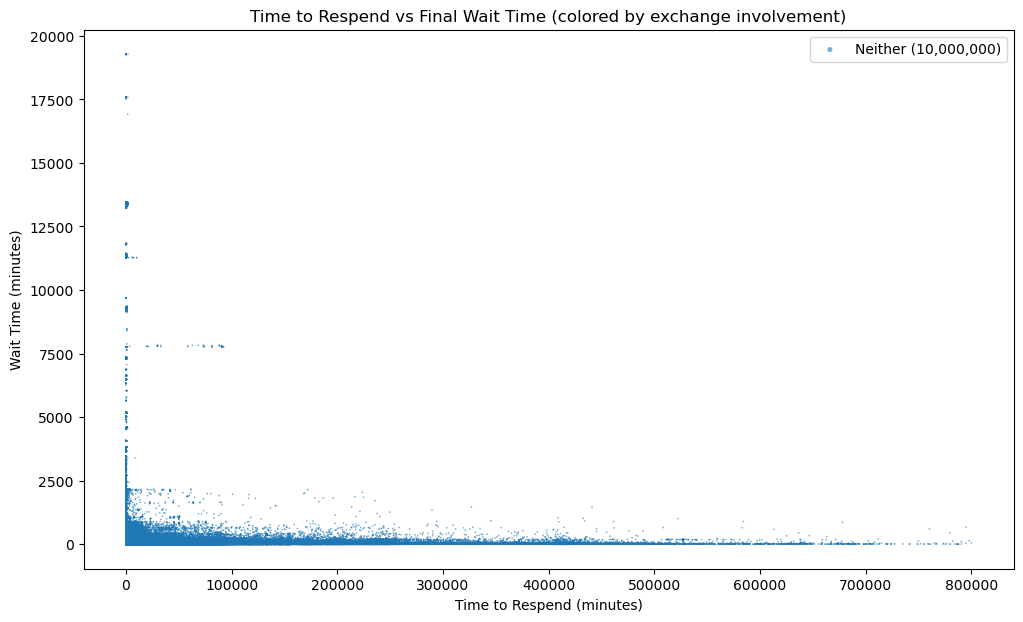

Correlation between time-to-respend and wait-time: -0.008

Exchange Involvement:
  Neither: 10,000,000 (100.0%)
  Exchange Sender: 0 (0.0%)
  Exchange Receiver: 0 (0.0%)
  Both: 0 (0.0%)


In [29]:
# Scatter: time to respend vs wait time (for respent txs only)
# Color-coded by exchange involvement

# Build plotting dataframe and drop NaNs to avoid color mapping issues
plot_df = pd.DataFrame({
    'time_to_respend_min': txs['min_respend_time'],
    'wait_time_min': (txs['waittime'] / 60),
    'exchange_is_sender': txs['exchange_is_sender'],
    'exchange_is_receiver': txs['exchange_is_receiver']
}).dropna()

# Create exchange category
# 0 = Neither, 1 = Sender only, 2 = Receiver only, 3 = Both
plot_df['exchange_category'] = 0  # Default: neither
plot_df.loc[plot_df['exchange_is_sender'] & ~plot_df['exchange_is_receiver'], 'exchange_category'] = 1
plot_df.loc[~plot_df['exchange_is_sender'] & plot_df['exchange_is_receiver'], 'exchange_category'] = 2
plot_df.loc[plot_df['exchange_is_sender'] & plot_df['exchange_is_receiver'], 'exchange_category'] = 3

# Optional downsample for rendering performance
max_points = 10000000
if len(plot_df) > max_points:
    plot_df = plot_df.sample(max_points, random_state=42)

# Define colors and labels for each category
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red
labels = ['Neither', 'Exchange Sender', 'Exchange Receiver', 'Both']
category_counts = plot_df['exchange_category'].value_counts().sort_index()

plt.figure(figsize=(12, 7))

# Plot each category separately to create legend
for cat in range(4):
    mask = plot_df['exchange_category'] == cat
    if mask.sum() > 0:
        plt.scatter(
            plot_df.loc[mask, 'time_to_respend_min'],
            plot_df.loc[mask, 'wait_time_min'],
            c=colors[cat],
            s=6,
            marker='.',
            edgecolors='none',
            alpha=0.6,
            label=f'{labels[cat]} ({category_counts.get(cat, 0):,})'
        )

plt.xlabel('Time to Respend (minutes)')
plt.ylabel('Wait Time (minutes)')
plt.title('Time to Respend vs Final Wait Time (colored by exchange involvement)')
plt.legend(loc='upper right', markerscale=3)
plt.show()

# Correlation (uncolored)
corr = np.corrcoef(txs['waittime'].dropna(), txs['min_respend_time'].dropna())[0, 1]
print(f"Correlation between time-to-respend and wait-time: {corr:.3f}")

# Exchange involvement stats
print(f"\nExchange Involvement:")
print(f"  Neither: {category_counts.get(0, 0):,} ({category_counts.get(0, 0)/len(plot_df):.1%})")
print(f"  Exchange Sender: {category_counts.get(1, 0):,} ({category_counts.get(1, 0)/len(plot_df):.1%})")
print(f"  Exchange Receiver: {category_counts.get(2, 0):,} ({category_counts.get(2, 0)/len(plot_df):.1%})")
print(f"  Both: {category_counts.get(3, 0):,} ({category_counts.get(3, 0)/len(plot_df):.1%})")